# Classifier

This challenge involves an **extreme multilabel classification** problem, where multiple content items are associated with multiple topics. Rather than training a conventional classifier across all 76,000 topics—which would be computationally expensive and complex—we adopt a **pairwise binary classification** approach.

To build the pairwise binary classifier, the following steps are taken:

1. **Preprocess content text**:

   * Use the `text` field from the content dataset.
   * If `text` is missing, fall back to the `description`.
   * If both are missing, use the `title`.

2. **Truncate the text**:

   * Keep only the first 100 characters to train a BLSTM model for language classification and embedding generation.

3. **Tokenize** the text using the `bert-base-uncased` tokenizer.

4. **Train a BLSTM model** for language classification:

   * Extract the hidden layer just before the output as a learned embedding.
   * These embeddings, along with additional features, will be used to train the pairwise binary classifier.

5. **Generate embeddings**:

   * Create embeddings for all content items.
   * Process the topics dataset similarly: if `description` is missing, use `title`, then generate embeddings for each topic.

6. **Build the dataset for pairwise classification**:

   * Collect positive pairs from the provided topic-content correlations.
   * Generate `k_neg` negative samples by pairing topics and contents that are not correlated.

7. **Train a LightGBM classifier** on these positive and negative pairs to perform **pairwise binary classification**.

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMClassifier
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, GlobalMaxPool1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotUniform, RandomUniform
from tensorflow.keras.utils import to_categorical

from transformers import AutoTokenizer

2025-07-09 23:35:35.474675: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-09 23:35:35.977934: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/rtx/anaconda3/envs/tf2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## BLSTM Embeddings

In [2]:
# Constants for training ansd stabilizing the model
EPOCHS = 5

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

text_column = 'text_100'
label_columns = 'lang_id'

In [3]:
# Loading the data
df_content = pd.read_csv("./learning-equality-curriculum-recommendations/content.csv")
df_content.head()

,id,title,description,kind,text,language,copyright_holder,license
0,c_00002381196d,"Sumar números de varios dígitos: 48,029+233,930","Suma 48,029+233,930 mediante el algoritmo está...",video,NaN,es,NaN,NaN
1,c_000087304a9e,Trovare i fattori di un numero,Sal trova i fattori di 120.\n\n,video,NaN,it,NaN,NaN
2,c_0000ad142ddb,Sumar curvas de demanda,Cómo añadir curvas de demanda\n\n,video,NaN,es,NaN,NaN
3,c_0000c03adc8d,Nado de aproximação,Neste vídeo você vai aprender o nado de aproxi...,document,\nNado de aproximação\nSaber nadar nas ondas ...,pt,Sikana Education,CC BY-NC-ND
4,c_00016694ea2a,geometry-m3-topic-a-overview.pdf,geometry-m3-topic-a-overview.pdf,document,Estándares Comunes del Estado de Nueva York\n\...,es,Engage NY,CC BY-NC-SA


In [4]:
df_content['text'] = df_content['text'].fillna(df_content['description'])
df_content['text'] = df_content['text'].fillna(df_content['title'])

# "Create a new column with the first 100 characters"
df_content[text_column] = df_content['text'].str.slice(0, 100)

In [5]:
# Encoding language labels
le = LabelEncoder()
df_content[label_columns] = le.fit_transform(df_content['language'])
num_classes = df_content[label_columns].nunique()

In [6]:
df_content.head()

,id,title,description,kind,text,language,copyright_holder,license,text_100,lang_id
0,c_00002381196d,"Sumar números de varios dígitos: 48,029+233,930","Suma 48,029+233,930 mediante el algoritmo está...",video,"Suma 48,029+233,930 mediante el algoritmo está...",es,NaN,NaN,"Suma 48,029+233,930 mediante el algoritmo está...",5
1,c_000087304a9e,Trovare i fattori di un numero,Sal trova i fattori di 120.\n\n,video,Sal trova i fattori di 120.\n\n,it,NaN,NaN,Sal trova i fattori di 120.\n\n,10
2,c_0000ad142ddb,Sumar curvas de demanda,Cómo añadir curvas de demanda\n\n,video,Cómo añadir curvas de demanda\n\n,es,NaN,NaN,Cómo añadir curvas de demanda\n\n,5
3,c_0000c03adc8d,Nado de aproximação,Neste vídeo você vai aprender o nado de aproxi...,document,\nNado de aproximação\nSaber nadar nas ondas ...,pt,Sikana Education,CC BY-NC-ND,\nNado de aproximação\nSaber nadar nas ondas ...,18
4,c_00016694ea2a,geometry-m3-topic-a-overview.pdf,geometry-m3-topic-a-overview.pdf,document,Estándares Comunes del Estado de Nueva York\n\...,es,Engage NY,CC BY-NC-SA,Estándares Comunes del Estado de Nueva York\n\...,5


### Tokenizer

In [7]:
texts = df_content[text_column].astype(str).values
labels = to_categorical(df_content[label_columns], num_classes=num_classes)

In [8]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
tokens = tokenizer(list(texts), padding='max_length', truncation=True, return_tensors="tf")
max_len=tokenizer.model_max_length
max_words = tokenizer.vocab_size

2025-07-09 23:35:51.642861: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-09 23:35:51.643007: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-09 23:35:51.659625: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [9]:
X_seq = tokens["input_ids"].numpy()

In [10]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, labels, test_size=0.2, random_state=SEED)
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

### BLSTM network

In [11]:
input_layer = Input(shape=(max_len,))

x = Embedding(input_dim=max_words, output_dim=128,
              embeddings_initializer=RandomUniform(seed=SEED))(input_layer)
x = Bidirectional(LSTM(64, return_sequences=True,
                       kernel_initializer=GlorotUniform(seed=SEED),
                       recurrent_initializer=GlorotUniform(seed=SEED),
                       bias_initializer='zeros'))(x)
x = Dropout(0.3)(x)
x = GlobalMaxPool1D()(x)
feature_output = x  # Embedding output
x = Dense(64, activation='relu',
          kernel_initializer=GlorotUniform(seed=SEED),
          bias_initializer='zeros')(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax',
                     kernel_initializer=GlorotUniform(seed=SEED),
                     bias_initializer='zeros')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(
    optimizer=Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512)]             0         
                                                                 
 embedding (Embedding)       (None, 512, 128)          3906816   
                                                                 
 bidirectional (Bidirection  (None, 512, 128)          98816     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 512, 128)          0         
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 64)                8256  

In [12]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=32,
    validation_split=0.1,
)

Epoch 1/5


2025-07-09 23:35:56.324940: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-07-09 23:35:56.341102: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-07-09 23:35:56.350024: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2b796810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-07-09 23:35:56.350037: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-07-09 23:35:56.350041: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 2080 SUPER, Compute Capability 7.5
2025-07-09 23:35:56.353056: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-0

3467/3467 [==============================] - 154s 44ms/step - loss: 0.4659 - accuracy: 0.8873 - val_loss: 0.2447 - val_accuracy: 0.9446
Epoch 2/5
3467/3467 [==============================] - 124s 36ms/step - loss: 0.2183 - accuracy: 0.9438 - val_loss: 0.1881 - val_accuracy: 0.9508
Epoch 3/5
3467/3467 [==============================] - 121s 35ms/step - loss: 0.1638 - accuracy: 0.9553 - val_loss: 0.1716 - val_accuracy: 0.9537
Epoch 4/5
3467/3467 [==============================] - 122s 35ms/step - loss: 0.1352 - accuracy: 0.9609 - val_loss: 0.1705 - val_accuracy: 0.9557
Epoch 5/5
3467/3467 [==============================] - 121s 35ms/step - loss: 0.1176 - accuracy: 0.9640 - val_loss: 0.1746 - val_accuracy: 0.9547


In [13]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

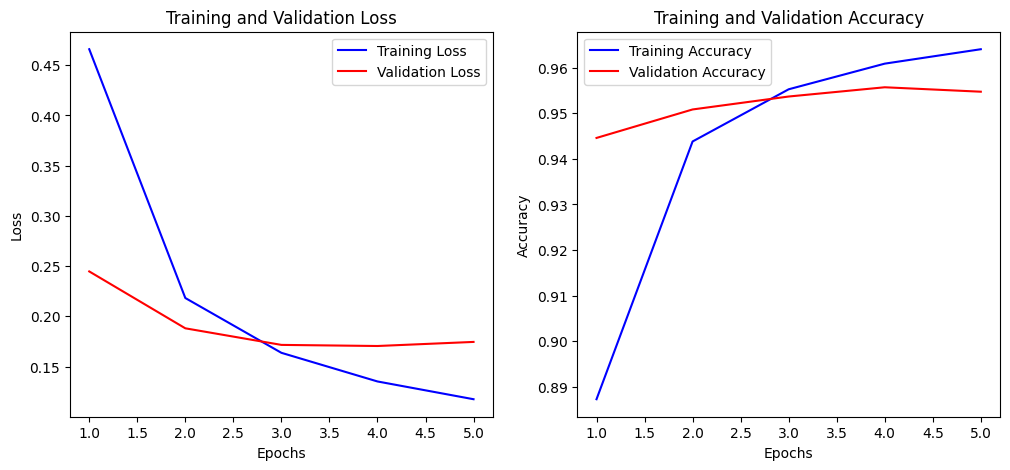

In [14]:
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

# Plot of the loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot of the accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [15]:
output_dir = "./blstm_supervised"
os.makedirs(output_dir, exist_ok=True)

# Save model and tokenizer
model.save(os.path.join(output_dir, "blstm.h5"))
with open(os.path.join(output_dir, "tokenizer.pkl"), "wb") as f:
    pickle.dump(tokenizer, f)
print(f"Model saved to {output_dir}")

Model saved to ./blstm_supervised


/home/rtx/anaconda3/envs/tf2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
y_pred_prob_blstm = model.predict(X_test, batch_size=32)  # Predict probabilities
y_pred_blstm = (y_pred_prob_blstm >= 0.5).astype(int)      # Apply threshold

print("=== BLSTM ===")
print(classification_report(y_test, y_pred_blstm, zero_division=0))

963/963 [==============================] - 10s 10ms/step
=== BLSTM ===
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1489
           1       0.81      0.82      0.82       137
           2       0.99      1.00      0.99      1190
           3       0.99      0.90      0.94       505
           4       0.97      0.96      0.97     13286
           5       0.97      0.95      0.96      6201
           6       0.85      0.65      0.74        92
           7       0.98      0.99      0.98      2108
           8       0.93      0.90      0.91       708
           9       0.97      0.85      0.91       819
          10       0.90      0.79      0.85       258
          11       0.81      0.82      0.82       107
          12       0.92      0.78      0.85       105
          13       0.86      0.65      0.74       186
          14       0.00      0.00      0.00        42
          15       0.98      0.71      0.83        63
          

## Create embedding datasets
Creating the datasets for the classifier, both the content and the topics are passed throught the BLSTM

In [17]:
# Create the feature extractor using the trained BLSTM
feature_extractor = Model(inputs=input_layer, outputs=feature_output)

### Content Embedding Dataset

In [18]:
X_features = feature_extractor.predict(X_seq, batch_size=32)

4814/4814 [==============================] - 53s 11ms/step


In [19]:
df = pd.concat([pd.DataFrame(X_features), df_content[["id", "kind", "language", "copyright_holder", "license"]]], axis=1)

In [20]:
df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,123,124,125,126,127,id,kind,language,copyright_holder,license
0,-0.029045,-0.007918,0.148729,0.052155,-0.019127,0.159318,0.026405,0.044169,0.119432,-0.086094,...,0.01108,0.089207,-0.003463,0.053717,0.162896,c_00002381196d,video,es,NaN,NaN


In [21]:
# Saving the content dataset
df.to_csv('embedding_content_dataset.csv', index=False)

### Topics Embedding Dataset

In [22]:
df_topics = pd.read_csv("./learning-equality-curriculum-recommendations/topics.csv")  

In [23]:
df_topics['description'] = df_topics['description'].fillna(df_topics['title'])

In [24]:
df_topics.head()

,id,title,description,channel,category,level,language,parent,has_content
0,t_00004da3a1b2,Откриването на резисторите,"Изследване на материали, които предизвикват на...",000cf7,source,4,bg,t_16e29365b50d,True
1,t_000095e03056,Unit 3.3 Enlargements and Similarities,Unit 3.3 Enlargements and Similarities,b3f329,aligned,2,en,t_aa32fb6252dc,False
2,t_00068291e9a4,Entradas e saídas de uma função,Entenda um pouco mais sobre funções.,8e286a,source,4,pt,t_d14b6c2a2b70,True
3,t_00069b63a70a,Transcripts,Transcripts,6e3ba4,source,3,en,t_4054df11a74e,True
4,t_0006d41a73a8,Графики на експоненциални функции (Алгебра 2 н...,Научи повече за графиките на сложните показате...,000cf7,source,4,bg,t_e2452e21d252,True


In [25]:
tokens_topics = tokenizer(list(df_topics["description"].astype(str).values), padding='max_length', truncation=True, return_tensors="tf")
X_topics = tokens_topics["input_ids"].numpy()

In [26]:
X_features_topics = feature_extractor.predict(X_topics, batch_size=32)

2406/2406 [==============================] - 20s 8ms/step


In [27]:
df_embedding_topics = pd.concat([pd.DataFrame(X_features_topics), df_topics[["id", "category", "level", "language", "has_content"]]], axis=1)

In [28]:
df_embedding_topics.head(1)

,0,1,2,3,4,5,6,7,8,9,...,123,124,125,126,127,id,category,level,language,has_content
0,0.270418,0.096776,0.375262,0.034639,0.699114,0.458029,0.119681,0.55922,0.015403,0.912186,...,0.183504,0.234053,0.367849,0.594572,0.051204,t_00004da3a1b2,source,4,bg,True


In [29]:
df_embedding_topics.to_csv('embedding_topics_dataset.csv', index=False)

## Classifier

### Creating classifier dataset

In [30]:
df_correlations = pd.read_csv("./learning-equality-curriculum-recommendations/correlations.csv")
df_correlations.head(1)

,topic_id,content_ids
0,t_00004da3a1b2,c_1108dd0c7a5d c_376c5a8eb028 c_5bc0e1e2cba0 c...


In [31]:
df_correlations['content_ids'] = df_correlations['content_ids'].str.split()
df_correlations.head(1)

,topic_id,content_ids
0,t_00004da3a1b2,"[c_1108dd0c7a5d, c_376c5a8eb028, c_5bc0e1e2cba..."


In [32]:
df_exploded = df_correlations.explode('content_ids')

In [33]:
df_exploded.head()

,topic_id,content_ids
0,t_00004da3a1b2,c_1108dd0c7a5d
0,t_00004da3a1b2,c_376c5a8eb028
0,t_00004da3a1b2,c_5bc0e1e2cba0
0,t_00004da3a1b2,c_76231f9d0b5e
1,t_00068291e9a4,c_639ea2ef9c95


In [34]:
all_topics = df_exploded['topic_id'].unique().tolist()

In [35]:
# Matching set for fast access
match_set = set(zip(df_exploded['content_ids'], df_exploded['topic_id']))

In [36]:
# Creating the positive samples with the correlations provided
pos_df = df_exploded.copy()
pos_df['label'] = 1

In [37]:
topic_to_idx = {t: i for i, t in enumerate(all_topics)}

# Creating a dictionary for fast access 
content_pos_topics = df_exploded.groupby('content_ids')['topic_id'].apply(set).to_dict()
k_neg = 5  # negativos por positivo
neg_samples = []

content_ids = df['id'].values
num_topics = len(all_topics)
print("Generating negative samples...")

for content_id in tqdm(content_ids):
    pos_topics = content_pos_topics.get(content_id, set())
    
    # Boolean mask for positive topics
    mask = np.ones(num_topics, dtype=bool)
    pos_idx = [topic_to_idx[t] for t in pos_topics if t in topic_to_idx]
    mask[pos_idx] = False
    
    # Indices de topics negativos posibles
    neg_indices = np.where(mask)[0]
    
    if len(neg_indices) < k_neg:
        continue
    
    # Topics for negative sample
    sampled_neg_idx = np.random.choice(neg_indices, size=k_neg, replace=False)
    sampled_neg_topics = [all_topics[i] for i in sampled_neg_idx]
    
    for topic in sampled_neg_topics:
        neg_samples.append((content_id, topic, 0))

neg_df = pd.DataFrame(neg_samples, columns=['content_ids', 'topic_id', 'label'])

Generating negative samples...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 154047/154047 [01:35<00:00, 1615.64it/s]


In [38]:
# concatenate positive and negative samples for the dataset
all_pairs = pd.concat([
    pos_df[['content_ids', 'topic_id', 'label']],
    neg_df
])

all_pairs = all_pairs.sample(frac=1, random_state=SEED).reset_index(drop=True)

In [39]:
all_pairs.head()

,content_ids,topic_id,label
0,c_083f000358e3,t_b91213331a9b,0
1,c_7d6e11ae72a4,t_f5bdaf35cc07,0
2,c_63f65fd7a509,t_a2c514a788b5,1
3,c_28cb046ac5a8,t_67665e1d4e18,0
4,c_b8bd65823bbb,t_c8c925d2cbb1,1


In [40]:
# Add all the information from the content
all_data = all_pairs.merge(df, left_on='content_ids', right_on = 'id', how='left')

In [41]:
# Add all the information form topic
all_data = all_data.merge(df_embedding_topics, left_on='topic_id', right_on='id', how='left', suffixes=('_content' ,'_topic'))

In [42]:
all_data.head()

,content_ids,topic_id,label,0_content,1_content,2_content,3_content,4_content,5_content,6_content,...,123_topic,124_topic,125_topic,126_topic,127_topic,id_topic,category,level,language_topic,has_content
0,c_083f000358e3,t_b91213331a9b,0,0.685912,0.118823,0.798488,0.030272,0.691047,0.086281,0.204150,...,0.062866,0.405428,0.129132,0.577228,0.026053,t_b91213331a9b,source,4,bg,True
1,c_7d6e11ae72a4,t_f5bdaf35cc07,0,0.686157,0.011534,0.280021,0.058840,0.750983,0.061573,0.020864,...,0.074142,0.070906,0.535933,-0.024203,0.267768,t_f5bdaf35cc07,aligned,4,en,True
2,c_63f65fd7a509,t_a2c514a788b5,1,0.352810,-0.023795,0.250078,0.032359,0.475884,0.033221,0.016234,...,0.420556,-0.016604,-0.016789,-0.027947,0.014673,t_a2c514a788b5,source,2,en,True
3,c_28cb046ac5a8,t_67665e1d4e18,0,0.878607,0.026717,0.543181,0.030895,0.880961,0.362182,0.088685,...,0.358192,0.594417,0.616691,0.404807,0.051293,t_67665e1d4e18,source,5,en,True
4,c_b8bd65823bbb,t_c8c925d2cbb1,1,0.194232,-0.003173,0.854552,0.034785,0.308467,0.022273,0.011595,...,0.688523,0.099294,0.668607,0.134442,0.014673,t_c8c925d2cbb1,source,4,en,True


In [43]:
categorical_cols = [
    "kind",
    "language_content",
    "copyright_holder",
    "license",
    "category",
    "language_topic"
]

for col in categorical_cols:
    all_data[col] = all_data[col].astype("category")

In [44]:
# Creating X and y 
X = all_data.drop(columns=['content_ids', 'topic_id', 'id_content', 'id_topic', 'label'])
y = all_data['label']

### Creating LightGBM pairwise binary classifier

In [45]:
X_train_lgb, X_val_lgb, y_train_lgb, y_val_lgb = train_test_split(X, y, test_size=0.2, random_state=SEED)

model_lgb = LGBMClassifier(
    objective='binary',
    learning_rate=0.05,
    n_estimators=100,
    random_state=SEED
)

model_lgb.fit(X_train_lgb, y_train_lgb)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[LightGBM] [Info] Number of positive: 224228, number of negative: 615895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.280162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65450
[LightGBM] [Info] Number of data points in the train set: 840123, number of used features: 263
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.266899 -> initscore=-1.010413
[LightGBM] [Info] Start training from score -1.010413


LGBMClassifier(learning_rate=0.05, objective='binary', random_state=42)

In [46]:
# Evaluate
y_pred = model_lgb.predict(X_val_lgb)
y_prob = model_lgb.predict_proba(X_val_lgb)[:, 1]

print(f'F1 Score: {f1_score(y_val_lgb, y_pred):.4f}')
print(f'AUC: {roc_auc_score(y_val_lgb, y_prob):.4f}')

F1 Score: 0.8577
AUC: 0.9745


In [47]:
with open("model_lgb.pkl", "wb") as f:
    pickle.dump(model_lgb, f)

In [48]:
print("=== LightGBM ===")
print(classification_report(y_val_lgb, y_pred, zero_division=0))

=== LightGBM ===
              precision    recall  f1-score   support

           0       0.96      0.94      0.95    154340
           1       0.84      0.88      0.86     55691

    accuracy                           0.92    210031
   macro avg       0.90      0.91      0.90    210031
weighted avg       0.92      0.92      0.92    210031

